# YOLO: обучение, инференс

[Ultralytics YOLO v8](https://learnopencv.com/ultralytics-yolov8/) вобрала в себя все последние достижения и находки из разных архитектур НС для задач компьютерного зрения. А сами Ultralytics сделали ее использование очень удобным. Итог: эффективная, универсальная по задачам, удобная Платформа компьютерного зрения. YOLO v8 вышла в 2023, недавно вышла уже YOLO v11.
- Задачи: классификация, детекция, сегментация, видео-трекинг, обнаружение позы
- Модели разлдичных размеров (гибкость выбора по соотношению "скорость-точность")
- Проект YOLO - open source (GPLv3)
- Работает с изображенями: **'bmp', 'dng', 'jpeg', 'jpg', 'mpo', 'png', 'tif', 'tiff', 'webp', 'pfm'**
- Работает с видео: **'asf', 'avi', 'gif', 'm4v', 'mkv', 'mov', 'mp4', 'mpeg', 'mpg', 'ts', 'wmv', 'webm'**


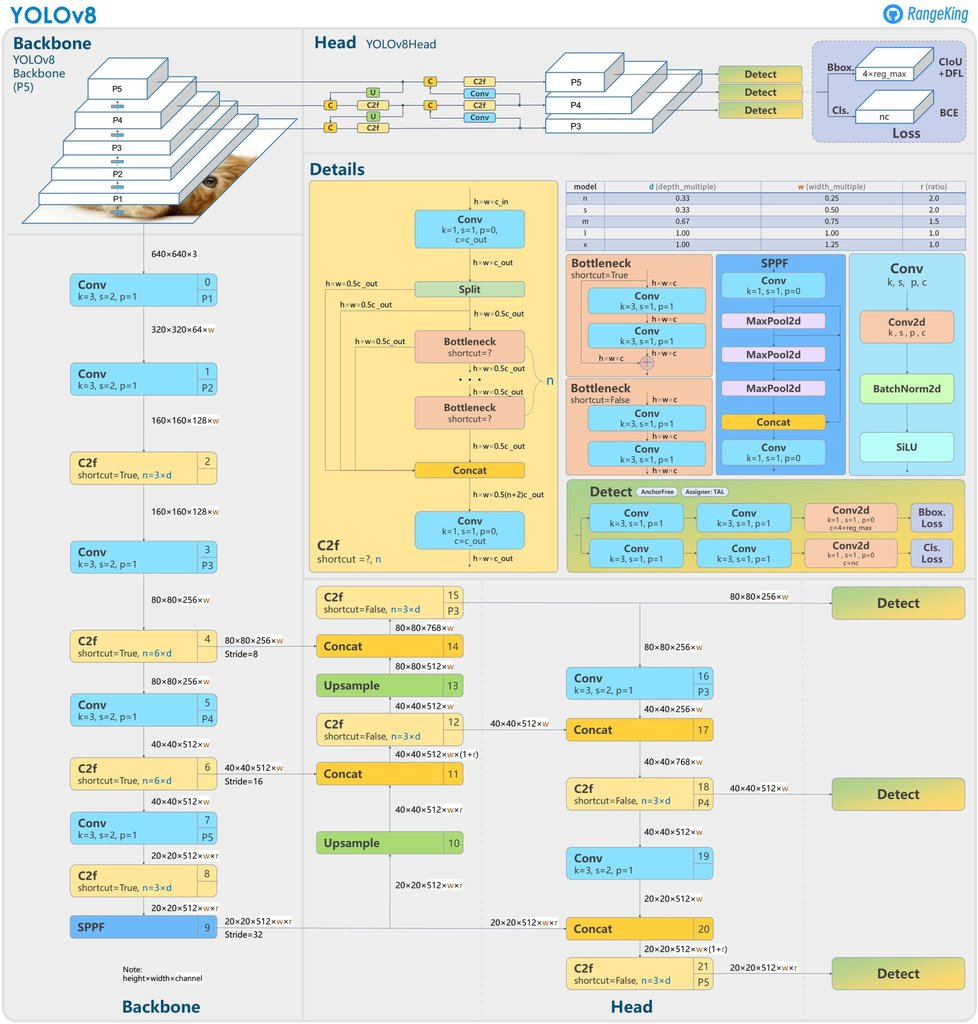


**Класс C2F** (coordinates-to-features), выделяющий и подающий далее в обработку признаки только внутри bbox

```python
class C2f(nn.Module):
    def __init__(self, c1, c2, n=1, shortcut=False, g=1, e=0.5):
        super().__init__()
        self.c = int(c2 * e)
        self.cv1 = Conv(c1, 2 * self.c, 1, 1)
        self.cv2 = Conv((2 + n) * self.c, c2, 1)
        self.m = nn.ModuleList(Bottleneck(self.c, self.c, shortcut, g, k=((3, 3), (3, 3)), e=1.0) for _ in range(n))

    def forward(self, x):
        y = list(self.cv1(x).chunk(2, 1))
        y.extend(m(y[-1]) for m in self.m)
        return self.cv2(torch.cat(y, 1))
```

**Модели детекции и сегменации различных размеров:**
- n (nano), 
- s (small), 
- m (medium), 
- l (large), 
- x (x-large)

Например, **```'yolo8m'```** - модель детекции размера **middle**, а **```'yolo8s-seg'```** - сегментационная модель размера **small**. Модель **```'yolo8х'```** **(x-large)** слишком большая для 12GB видеопамяти GPU.

Предобученная модель сегментации размера **nano**:

## Нота о конфиденциальности:
Особенности [сбора информации](https://github.com/ultralytics/ultralytics/issues/6405) Ultralytics и "анонимизации" пользователей ("псеводнимизация")

## Подготовка датсета для YOLO

### 1. Определем коды классов: 0, 1, 2 ... etc
- 0 --> cat
- 1 --> dog
- 2 --> preson
- ...

### 2. Общие моменты
Изображение может содержать один или несколько классов или экземпляров классов. Небольшая доля пустых изображений полезна - уменьшит количество FP. Разные классы: 100-500 изображений, похожие классы (породы собак): >1000 изображений.

### 3. Файл аннотации для каждого изображения
- Это должен быть <b> текстовый (.txt)</b> файл
- Название файла должно быть таким же, как и у исходного изображения
- Для обнаружения файл задания должен содержать строки с 5 значениями: <b>код класса Xc Yc W H</b>. Значения должны быть разделены пробелом. Каждая строка для отдельного объекта. <b>Xc</b> и <b>Yc</b> - координаты центра объекта, <b>W</b> и <b>H</b> - ширина и высота объекта bbox
- Для задачи сегментации файл должен содержать строки с N+1 значениями: <b>код класса x1 y1 x2 y2 x3 y3 ...</b>, первое значение - это код класса, а N - это x,y-парные значения для каждой точки контура. Значения, разделенные пробелом. Код класса - число от [0 до N-1](https://github.com/ultralytics/yolov5/issues/10621).
- Все координаты должны быть в относительных значениях по размеру изображения
- Для изображений без реальных классов: пустые файлы аннотаций или ничего (файлы не нужны). Рекомендуются пустые файлы

### 4.Общие рекомендации по набору данных
- Данные должны быть максимально сбалансированы: число объектов каждого класса должны быть примерно равны
- Каждый класс и каждый экземпляр должны быть размечены. Проверьте это!
- Максимальное разнообразие для одних и тех же классов: позы, породы, ракурсы, условия освещения, масштаб...
- Аннотация должна быть согласованной: если часть объекта на границе аннотирована на одном изображении, она должна быть аннотирована таким же образом на других изображениях. Если вырезанные объекты не помечены в одном изображении, они никогда не должны быть помечены в других и т.д. Строгие правила - вопрос выбора, зависит от задачи и предметной области, но они должны быть последовательными!
- 80% обучения + 20% проверки. Может быть (необязательно) еще и test, тогда: **60-20-20: train-val-test**
- Разделение на train и val обязательно и должно быть случайным

### 5. Cтруктура Проекта

### 6. YAML datafile
- path: project_directory
- train: 'train/images'
- val: 'valid/images'
- names: # class names

  - 0: 'adult'
  - 1: 'pup'
  ...

## Запуск обучения на собственных данных (пример)

### 1. Устанавливаем пакет Ultralytics:
- [С GitHub](https://github.com/ultralytics/ultralytics)
- C помощью pip

In [ ]:
# !git clone https://github.com/ultralytics/ultralytics.git
# !pip install -r requirements.txt

In [ ]:
# !pip install ultralytics

### 2. Импорт модулей, настройки воспроизводимости

In [ ]:
from ultralytics import YOLO
from ultralytics import settings
import torch
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
import random
import warnings

%matplotlib inline
warnings.filterwarnings("ignore")

seed = 42
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'torch version: {torch.__version__}, device: {device}')

### 3. Настройки YOLO
Вызываем словарь настроек (импортирован ранее), можно менять директории по умолчанию, откуда загружается датасет, и куда сохраняются результаты и другиме параметры:

In [ ]:
settings

In [ ]:
settings['datasets_dir'] # вывод значений настроек

In [ ]:
settings['runs_dir'] # вывод значений настроек

In [ ]:
settings.update({"runs_dir": "runs/2"}) # изменение конкретных настроек
settings['runs_dir']

### 4. Обучение
Поддерживается как **CLI-интерфейс** (интерфейс командной сроки), так и **python API**

**4.1 CLI-интерфейс:**
Общий формат: <b>yolo TASK MODE ARGS</b>

In [ ]:
# !yolo task=detect \ #classify, segment
# !mode=predict \ # train, val
# !model=yolov8n.pt \
# !source="image.jpg"

# !yolo task=detect mode=predict model=yolov8n.pt source='input/video_3.mp4' show=True
# !yolo task=segment mode=predict model=yolov8x-seg.pt source='input/video_3.mp4' show=True
# !yolo task=classify mode=predict model=yolov8x-cls.pt source='input/video_3.mp4' show=True

**4.2 python API:**

Модели разных размеров для детекции:

```python
model_n = YOLO("yolov8n.yaml")  # новая необученная модель (с нуля)
model_npt = YOLO("yolov8n.pt")  # предобученная на ImageNet

model_s = YOLO("yolov8s.yaml") # small
model_spt = YOLO("yolov8s.pt")

model_m = YOLO("yolov8m.yaml") # medium
model_mpt = YOLO("yolov8m.pt")

model_l = YOLO("yolov8l.yaml") # large
model_lpt = YOLO("yolov8l.pt")

model_x = YOLO("yolov8x.yaml") # x-large: не помещается на GeForce RTX3060 12Gb
model_xpt = YOLO("yolov8x.pt")
```

Модели разных размеров для сегментации:

```python
model_seg_n = YOLO("yolov8n-seg.yaml")  # новая необученная модель (с нуля)
model_seg_npt = YOLO("yolov8n-seg.pt")  # предобученная на СОСО

model_seg_s = YOLO("yolov8s-seg.yaml") # small
model_seg_spt = YOLO("yolov8s-seg.pt")

model_seg_m = YOLO("yolov8m-seg.yaml") # medium
model_seg_mpt = YOLO("yolov8m-seg.pt")

model_seg_l = YOLO("yolov8l-seg.yaml") # large
model_seg_lpt = YOLO("yolov8l-seg.pt")

model_seg_x = YOLO("yolov8x-seg.yaml") # x-large
model_seg_xpt = YOLO("yolov8x-seg.pt")
```

In [ ]:
model = YOLO('yolov8n-seg.pt')  # инициализируем пердобучнную модель сегментации

In [ ]:
model # структура модели

- Конфиг-файл для YOLO - файл с расширением .yaml, открывается как обычный текстовый файл с настройками и парметрами
- Вместо ```cfg.yaml``` вставьте свой cfg-файл, для примера даю **```bears_cfg.yaml```** отдельным файлом. Файл по умолчанию можно [посмотреть тут](https://github.com/ultralytics/ultralytics/blob/main/ultralytics/yolo/cfg/default.yaml).

In [ ]:
model.train(data='cfg.yaml', batch=16, epochs=30, imgsz=640) # обучаем

Можно присвоить результаты обучения переменной (это будет python-объект **"generator"**, который работает в цикле), [см. документацию](https://docs.ultralytics.com/modes/predict/#key-features-of-predict-mode):


In [ ]:
# results = model.train(data='bears_perimeter.yaml', batch=16, epochs=30, imgsz=640)

# for result in results:
    # pass #(processing)

### 5. Проверка модели

In [ ]:
# проверка модели
metrics = model.val()
metrics

### 6. Инференс (применение на новых данных)
Для инференса можно указать директорию или источник (в т.ч. вебкамеру), а также тип файлов - как изображения, так и видео.
Форматы источников: 
- image
- dir
- Path
- URL
- video
- PIL
- ndarray

```python
results = model.predict(source="0", show=True) # 0 для запуска с веб-камеры

im1 = Image.open('./test/smAAI29INHA.jpg') # запуск на PIL-изображении
results = model.predict(source=im1, save=True)  # сохраняем результаты на изображениях

results = model.predict(source=[im1, im2]) # запуск на списке PIL-изображений или массивов ndarray

im2 = cv2.imread('./test/img.jpg') # читаем с помощью opencv изображение в форме ndarray по адресу
results = model.predict(source=im2, save=True, save_txt=True)  # сохраняем результаты, предсказанную разметку
```

**Применяем обученную модель** (и сравниваем результат с таковым для модели на 300 эпохах и большом датасете):

In [ ]:
folder = 'Path/to/your/images/folder' # вставить путь к директории с изображениями
results = model.predict(source=folder, save=True, save_txt=True)

### 7. Экспорт в ONNX
**ONNX**[(Open Neural Network Exchange)](https://ru.wikipedia.org/wiki/ONNX) - открытый формат обмена обученными моделями между различными DL-фреймфорками.

In [ ]:
import onnx

model.fuse()  
model.info(verbose=True)  # информация о модели
best_saved = model.export(format="onnx")
best_saved

## Подготовка датасета для YOLO
- Подготовка собственного датасета: https://www.youtube.com/watch?v=wM1wn1bZ3S4
- Общие недостатки в датасетах для детекции: https://www.youtube.com/watch?v=40GqhTrMcNA
- YOLOX с дадасетом дронов: https://learnopencv.com/yolox-object-detector-paper-explanation-and-custom-training/

## Документация:
- Основы python API: https://docs.ultralytics.com/usage/python/
- Полный список аргументов: https://github.com/ultralytics/ultralytics/blob/main/ultralytics/yolo/cfg/default.yaml
- Python-документация: https://docs.ultralytics.com/usage/python/